In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold, GridSearchCV
import os

In [2]:
####assemble data into a single data frame

#function to read in modelled decoding time data and normalise to mean
def read_rrt(p,file_name):
    df = pd.read_csv(p + file_name)
    if not 'W' in file_name:
        colname = 'base config'
    else:
        colname = file_name[:-4].replace('Wo_','')
    df.columns = [df.columns[0],colname]
    
    return df

#read in filenames
file_names = os.listdir('decoding_times_out_new/')
file_names = [file for file in file_names if file[0] == 'W']

#initiate dataframe with baseline data
raw_df = read_rrt('decoding_times_out_new/','base_configuration.csv')
for file_name in file_names:
    add_df = read_rrt('decoding_times_out_new/',file_name)
    raw_df = raw_df.merge(add_df,on='codon')

#read in experimental RRT file names
file_names = os.listdir('Codon data/')
file_names = [file for file in file_names if file[0] != '.']

#add experimental RRT data (RRTs are already normalised)
for file_name in file_names:
    add_df = pd.read_csv('Codon data/' + file_name)
    add_df['codon'] = add_df['codon'].str.replace('T','U')
    add_df.columns = [add_df.columns[0],file_name[:-4]]
    raw_df = raw_df.merge(add_df,on='codon')

raw_df = raw_df.set_index('codon')
raw_df = raw_df.iloc[:,0:].T

In [3]:
#scale the data using different approaches

#normalise to mean
norm_temp = []
for row in raw_df.iterrows():
    norm_temp.append(row[1] / np.mean(row[1]))
norm_data = np.array(norm_temp)

#use Scikit Learn standard scaler
stdscaler = StandardScaler()
sscale_data = stdscaler.fit_transform(raw_df)

#use Scikit Learn minmax scaler
mmscaler = MinMaxScaler()
mmscale_data = mmscaler.fit_transform(raw_df)

<h2>Principal Components</h2>

In [5]:
#fit 2D PCA
pca_data = []
pca_data.append(PCA(n_components=2).fit_transform(norm_data))
pca_data.append(PCA(n_components=2).fit_transform(sscale_data))
pca_data.append(PCA(n_components=2).fit_transform(mmscale_data))

#identify PCA clusters
pca_clusters = []
for pca_dataset in pca_data:
    pca_clusters.append(DBSCAN(eps=0.5, min_samples=10).fit(pca_dataset))

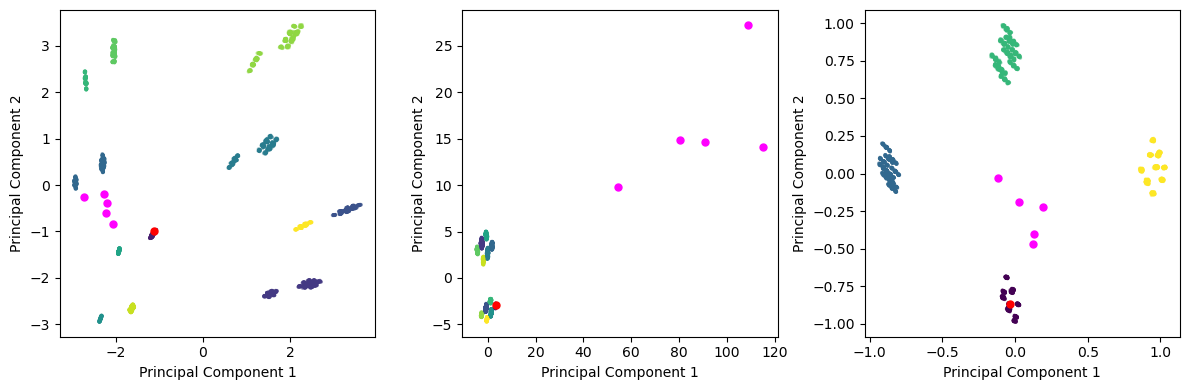

In [9]:
###Plot results

fig, axs = plt.subplots(1,3,figsize=(12,4))
for idx,pca_dataset in enumerate(pca_data):
    x = pca_dataset.T[0]
    y = pca_dataset.T[1]
    axs[idx].scatter(x,y,s=3,c=pca_clusters[idx].labels_,cmap='viridis',alpha = 0.5)
    axs[idx].scatter(x[0],y[0],c='red',s=25)
    axs[idx].scatter(x[-5:],y[-5:],c='magenta',s=25)
    axs[idx].set_xlabel('Principal Component 1')
    axs[idx].set_ylabel('Principal Component 2')
fig.tight_layout()
plt.savefig('Supp PCA.png')
plt.show()


<h2>t-SNE</h2>

In [6]:
#optimise the perplexity hyperparameter on the normalised data
perplexities = [0.5,1,10,20,50,75,100]
no_clusters =[]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    data = tsne.fit_transform(norm_data)
    get_clusters = DBSCAN(eps=5, min_samples=10).fit(data)
    no_clusters.append(max(get_clusters.labels_))

In [7]:
no_clusters

[7, 9, 191, 110, 44, 23, 23]

In [10]:
#fit 2D tSNE
choose_perplexity = 75
tsne_data = []
tsne_data.append(TSNE(n_components=2,perplexity=choose_perplexity).fit_transform(norm_data))
tsne_data.append(TSNE(n_components=2,perplexity=choose_perplexity).fit_transform(sscale_data))
tsne_data.append(TSNE(n_components=2,perplexity=choose_perplexity).fit_transform(mmscale_data))



In [11]:
#identify tSNE clusters
tsne_clusters = []
for tsne_dataset in tsne_data:
    tsne_clusters.append(DBSCAN(eps=0.5, min_samples=10).fit(tsne_dataset))

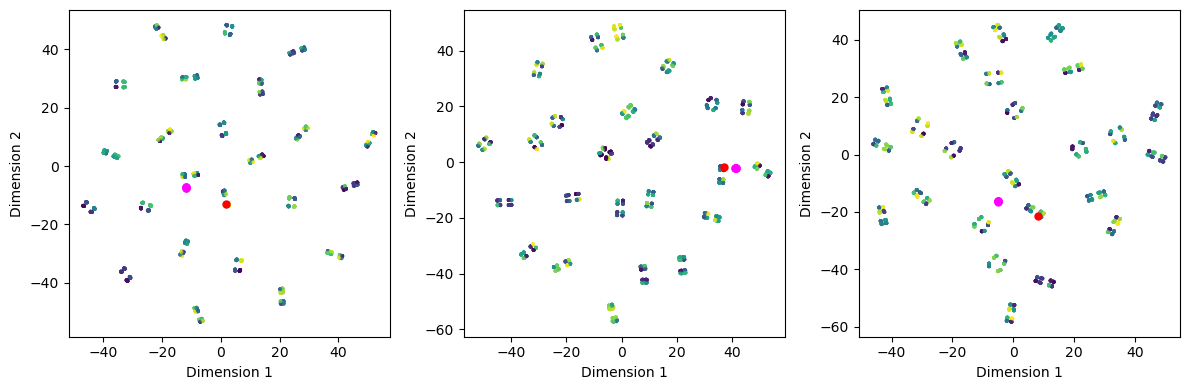

In [19]:
###Plot results

fig, axs = plt.subplots(1,3,figsize=(12,4))
for idx,tsne_dataset in enumerate(tsne_data):
    x = tsne_dataset.T[0]
    y = tsne_dataset.T[1]
    axs[idx].scatter(x,y,s=3,c=tsne_clusters[idx].labels_,cmap='viridis',alpha = 0.5)
    axs[idx].scatter(x[0],y[0],c='red',s=25)
    axs[idx].scatter(x[-5:],y[-5:],c='magenta',s=25)
    axs[idx].set_xlabel('Dimension 1')
    axs[idx].set_ylabel('Dimension 2')
fig.tight_layout()
plt.savefig('Supp tsne.png')
plt.show()

<h2>MDS</h2>

In [14]:
#######SLOW CELL - EXECUTION ~10 minutes##################
#fit 2D MDS
mds_data = []
mds_data.append(MDS(n_components=2,normalized_stress='auto',metric=True).fit_transform(norm_data))
mds_data.append(MDS(n_components=2,normalized_stress='auto',metric=True).fit_transform(sscale_data))
mds_data.append(MDS(n_components=2,normalized_stress='auto',metric=True).fit_transform(mmscale_data))

In [15]:
#identify MDS clusters
mds_clusters = []
for mds_dataset in mds_data:
    mds_clusters.append(DBSCAN(eps=0.5, min_samples=10).fit(mds_dataset))

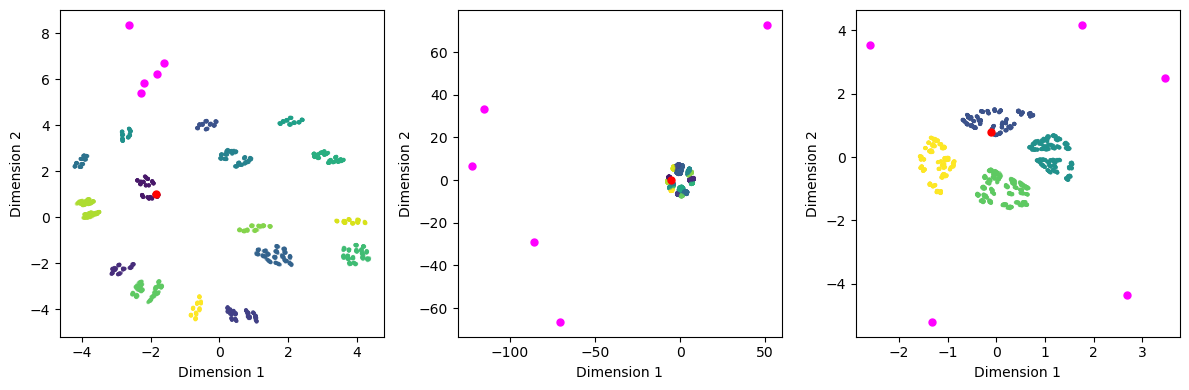

In [20]:
###Plot results

fig, axs = plt.subplots(1,3,figsize=(12,4))
for idx,mds_dataset in enumerate(mds_data):
    x = mds_dataset.T[0]
    y = mds_dataset.T[1]
    axs[idx].scatter(x,y,s=3,c=mds_clusters[idx].labels_,cmap='viridis',alpha = 0.5)
    axs[idx].scatter(x[0],y[0],c='red',s=25)
    axs[idx].scatter(x[-5:],y[-5:],c='fuchsia',s=25)
    axs[idx].set_xlabel('Dimension 1')
    axs[idx].set_ylabel('Dimension 2')
fig.tight_layout()
plt.savefig('Supp MDS.png')
plt.show()


<h2>Distance Recovery</h2>

In [17]:
#compare distances in original and reduced datasets for norm_data
x = euclidean_distances(norm_data).flatten()
y_pca = euclidean_distances(pca_data[0]).flatten()
y_tsne = euclidean_distances(tsne_data[0]).flatten()
y_mds = euclidean_distances(mds_data[0]).flatten()

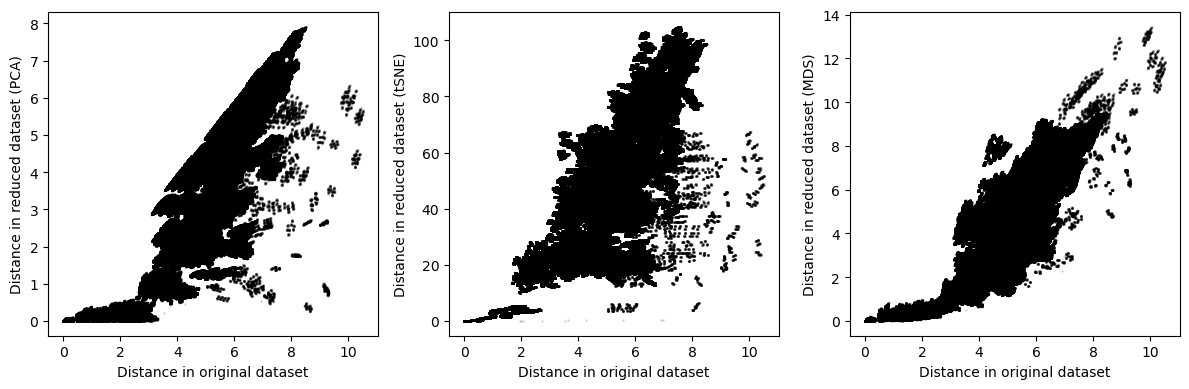

In [18]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].scatter(x,y_pca,s=1,alpha=0.05,c='black')
axs[0].set_xlabel('Distance in original dataset')
axs[0].set_ylabel('Distance in reduced dataset (PCA)')
axs[1].scatter(x,y_tsne,s=1,alpha=0.05,c='black')
axs[1].set_xlabel('Distance in original dataset')
axs[1].set_ylabel('Distance in reduced dataset (tSNE)')
axs[2].scatter(x,y_mds,s=1,alpha=0.05,c='black')
axs[2].set_xlabel('Distance in original dataset')
axs[2].set_ylabel('Distance in reduced dataset (MDS)')
fig.tight_layout()
plt.savefig('scaling_distances_comparison.png')
plt.show()